In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold

### Data Set Information:

The experiments have been carried out by means of a numerical simulator of a naval vessel (Frigate) characterized by a Gas Turbine (GT) propulsion plant. The different blocks forming the complete simulator (Propeller, Hull, GT, Gear Box and Controller) have been developed and fine tuned over the year on several similar real propulsion plants. In view of these observations the available data are in agreement with a possible real vessel.
In this release of the simulator it is also possible to take into account the performance decay over time of the GT components such as GT compressor and turbines.
The propulsion system behaviour has been described with this parameters:
- Ship speed (linear function of the lever position lp).
- Compressor degradation coefficient kMc.
- Turbine degradation coefficient kMt.
so that each possible degradation state can be described by a combination of this triple (lp,kMt,kMc).
The range of decay of compressor and turbine has been sampled with an uniform grid of precision 0.001 so to have a good granularity of representation.
In particular for the compressor decay state discretization the kMc coefficient has been investigated in the domain [1; 0.95], and the turbine coefficient in the domain [1; 0.975].
Ship speed has been investigated sampling the range of feasible speed from 3 knots to 27 knots with a granularity of representation equal to tree knots.
A series of measures (16 features) which indirectly represents of the state of the system subject to performance decay has been acquired and stored in the dataset over the parameter's space.


### Attribute Information:

- A 16-feature vector containing the GT measures at steady state of the physical asset:
Lever position (lp) [ ]
Ship speed (v) [knots]
Gas Turbine (GT) shaft torque (GTT) [kN m]
GT rate of revolutions (GTn) [rpm]
Gas Generator rate of revolutions (GGn) [rpm]
Starboard Propeller Torque (Ts) [kN]
Port Propeller Torque (Tp) [kN]
Hight Pressure (HP) Turbine exit temperature (T48) [C]
GT Compressor inlet air temperature (T1) [C]
GT Compressor outlet air temperature (T2) [C]
HP Turbine exit pressure (P48) [bar]
GT Compressor inlet air pressure (P1) [bar]
GT Compressor outlet air pressure (P2) [bar]
GT exhaust gas pressure (Pexh) [bar]
Turbine Injecton Control (TIC) [%]
Fuel flow (mf) [kg/s]
- GT Compressor decay state coefficient
- GT Turbine decay state coefficient

In [47]:
columns = ['lever_position', 'ship_speed', 'gt_shaft', 'gt_rate', 'gg_rate', 'sp_torque', 'pp_torque', \
                    'hpt_temp', 'gt_c_i_temp', 'gt_c_o_temp', 'hpt_pressure', 'gt_c_i_pressure', 'gt_c_o_pressure', \
                    'gt_exhaust_pressure', 'turbine_inj_control', 'fuel_flow', 'gt_c_decay',  'gt_t_decay']

df = pd.read_table('./datasets/data.txt',delim_whitespace=True,names=columns)

In [40]:
df

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_i_temp,gt_c_o_temp,hpt_pressure,gt_c_i_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,288.0,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11929,5.140,15.0,21624.934,1924.342,8470.013,175.239,175.239,681.658,288.0,628.950,2.087,0.998,10.990,1.027,23.803,0.471,1.00,1.000
11930,6.175,18.0,29763.213,2306.745,8800.352,245.954,245.954,747.405,288.0,658.853,2.512,0.998,13.109,1.031,32.671,0.647,1.00,1.000
11931,7.148,21.0,39003.867,2678.052,9120.889,332.389,332.389,796.457,288.0,680.393,2.982,0.998,15.420,1.036,42.104,0.834,1.00,1.000
11932,8.206,24.0,50992.579,3087.434,9300.274,438.024,438.024,892.945,288.0,722.029,3.594,0.998,18.293,1.043,58.064,1.149,1.00,1.000


In [41]:
df.isna().sum()

lever_position         0
ship_speed             0
gt_shaft               0
gt_rate                0
gg_rate                0
sp_torque              0
pp_torque              0
hpt_temp               0
gt_c_i_temp            0
gt_c_o_temp            0
hpt_pressure           0
gt_c_i_pressure        0
gt_c_o_pressure        0
gt_exhaust_pressure    0
turbine_inj_control    0
fuel_flow              0
gt_c_decay             0
gt_t_decay             0
dtype: int64

In [42]:
df.nunique()

lever_position             9
ship_speed                 9
gt_shaft               11430
gt_rate                 3888
gg_rate                11834
sp_torque               4286
pp_torque               4286
hpt_temp               11772
gt_c_i_temp                1
gt_c_o_temp            11506
hpt_pressure             524
gt_c_i_pressure            1
gt_c_o_pressure         4209
gt_exhaust_pressure       19
turbine_inj_control     8496
fuel_flow                696
gt_c_decay                51
gt_t_decay                26
dtype: int64

Βλέπουμε εδώ bro μου ότι κάποιες στήλες έχουν μόνο μια μοναδική τιμή οπότε άντε λα μαγκέτε βοτανίκ

In [48]:
df = df.drop(columns=['gt_c_i_temp','gt_c_i_pressure'],axis=1)

In [51]:
df.head()

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_o_temp,hpt_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,550.563,1.096,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,581.658,1.331,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,587.587,1.389,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,613.851,1.658,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,645.642,2.078,11.197,1.026,26.373,0.522,0.95,0.975


<AxesSubplot:>

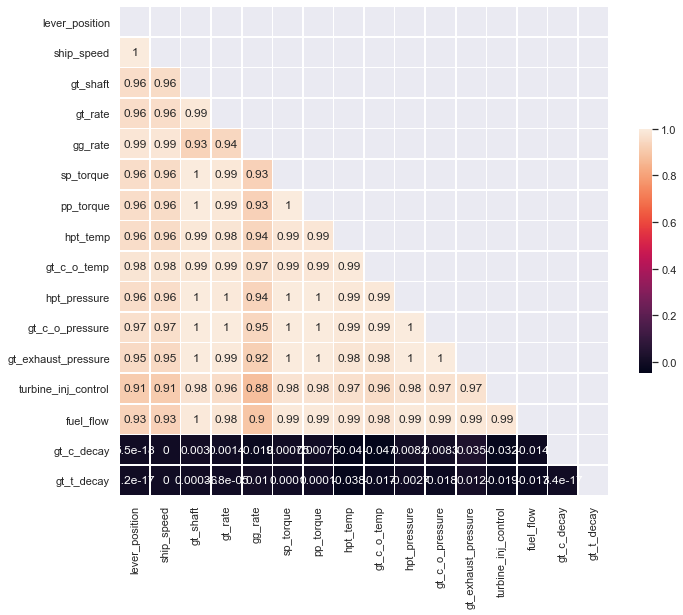

In [70]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,yticklabels = cols.values, xticklabels=cols.values)

In [71]:
df1 = df.drop(columns=['gt_t_decay'])
df2 = df.drop(columns=['gt_c_decay'])

In [88]:
from pycaret.regression import *

exp_reg102 = setup(data = df1, target = 'gt_c_decay', session_id=123,
                  normalize = True, transformation = True, 
                  combine_rare_levels = False, rare_level_threshold = 0.05,
                  remove_multicollinearity = False,
                  log_experiment = True, experiment_name = 'Naval',use_gpu=True)

,Description,Value
0,session_id,123
1,Target,gt_c_decay
2,Original Data,"(11934, 15)"
3,Missing Values,False
4,Numeric Features,14
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8353, 6)"


In [89]:
top3 = compare_models(exclude = ['ransac'], n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0004,0.0000,0.0008,0.9968,0.0004,0.0004,1.1020
rf,Random Forest Regressor,0.0006,0.0000,0.0013,0.9924,0.0006,0.0006,0.9960
xgboost,Extreme Gradient Boosting,0.0010,0.0000,0.0015,0.9893,0.0008,0.0010,0.7880
lightgbm,Light Gradient Boosting Machine,0.0011,0.0000,0.0017,0.9863,0.0009,0.0011,0.1250
dt,Decision Tree Regressor,0.0011,0.0000,0.0020,0.9820,0.0010,0.0011,0.0480
knn,K Neighbors Regressor,0.0010,0.0000,0.0022,0.9769,0.0011,0.0010,0.3100
gbr,Gradient Boosting Regressor,0.0039,0.0000,0.0051,0.8798,0.0026,0.0040,0.9680
lr,Linear Regression,0.0078,0.0001,0.0095,0.5851,0.0048,0.0080,0.0080
lar,Least Angle Regression,0.0078,0.0001,0.0095,0.5851,0.0048,0.0080,0.0080
br,Bayesian Ridge,0.0078,0.0001,0.0095,0.5851,0.0048,0.0080,0.0100


In [78]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0022,0.0000,0.0046,0.9019,0.0023,0.0023
1,0.0022,0.0000,0.0047,0.8946,0.0024,0.0023
2,0.0021,0.0000,0.0046,0.9084,0.0023,0.0022
3,0.0020,0.0000,0.0044,0.9100,0.0022,0.0021
4,0.0023,0.0000,0.0053,0.8744,0.0027,0.0024
5,0.0022,0.0000,0.0050,0.8792,0.0025,0.0023
6,0.0024,0.0000,0.0052,0.8770,0.0026,0.0024
7,0.0023,0.0000,0.0052,0.8742,0.0026,0.0023
8,0.0023,0.0000,0.0051,0.8840,0.0026,0.0023
9,0.0022,0.0000,0.0046,0.8994,0.0023,0.0022


In [83]:
tuned_et = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0110,0.0002,0.0129,0.2335,0.0065,0.0113
1,0.0110,0.0002,0.0130,0.2033,0.0066,0.0113
2,0.0116,0.0002,0.0135,0.2002,0.0068,0.0119
3,0.0112,0.0002,0.0131,0.2161,0.0066,0.0115
4,0.0118,0.0002,0.0136,0.1667,0.0069,0.0121
5,0.0112,0.0002,0.0130,0.1857,0.0066,0.0114
6,0.0113,0.0002,0.0131,0.2075,0.0067,0.0116
7,0.0112,0.0002,0.0131,0.1944,0.0066,0.0115
8,0.0118,0.0002,0.0136,0.1864,0.0069,0.0121
9,0.0113,0.0002,0.0132,0.1777,0.0067,0.0116


In [84]:
est = automl(optimize = 'MAE')

In [87]:
est

PowerTransformedTargetRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                powe...
                                regressor=ExtraTreesRegressor(bootstrap=False,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                             